In [247]:
import numpy as np
import pandas as pd
import talib
import pandas_ta as pta
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy import stats
from matplotlib import pyplot as plt
from decimal import ROUND_HALF_UP, Decimal

import warnings
warnings.filterwarnings('ignore')

In [5]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

In [47]:
df = pd.read_csv("/Users/admin/Desktop/stock_prices.csv")
df

RowId        Date  SecuritiesCode    Open    High     Low  \
0        20170104_1301  2017-01-04            1301  2734.0  2755.0  2730.0   
1        20170104_1332  2017-01-04            1332   568.0   576.0   563.0   
2        20170104_1333  2017-01-04            1333  3150.0  3210.0  3140.0   
3        20170104_1376  2017-01-04            1376  1510.0  1550.0  1510.0   
4        20170104_1377  2017-01-04            1377  3270.0  3350.0  3270.0   
...                ...         ...             ...     ...     ...     ...   
2332526  20211203_9990  2021-12-03            9990   514.0   528.0   513.0   
2332527  20211203_9991  2021-12-03            9991   782.0   794.0   782.0   
2332528  20211203_9993  2021-12-03            9993  1690.0  1690.0  1645.0   
2332529  20211203_9994  2021-12-03            9994  2388.0  2396.0  2380.0   
2332530  20211203_9997  2021-12-03            9997   690.0   711.0   686.0   

          Close   Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
0        2742.0    31400               1.0               NaN            False   
1         571.0  2798500               1.0               NaN            False   
2        3210.0   270800               1.0               NaN            False   
3        1550.0    11300               1.0               NaN            False   
4        3330.0   150800               1.0               NaN            False   
...         ...      ...               ...               ...              ...   
2332526   528.0    44200               1.0               NaN            False   
2332527   794.0    35900               1.0               NaN            False   
2332528  1645.0     7200               1.0               NaN            False   
2332529  2389.0     6500               1.0               NaN            False   
2332530   696.0   381100               1.0               NaN            False   

           Target  
0        0.000730  
1        0.012324  
2        0.006154  
3        0.011053  
4        0.003026  
...           ...  
2332526  0.034816  
2332527  0.025478  
2332528 -0.004302  
2332529  0.009098  
2332530  0.018414  

[2332531 rows x 12 columns]

In [48]:
df = adjust_price(df)
df['Close'] = df['AdjustedClose']
df = df.drop(columns='AdjustedClose')

In [222]:
class Indicators:

    def __init__(self, data):
        self.data = data

    def CCI(self, ndays: int = 20):
        """Commodity Channel Index"""

        cci = talib.CCI(self.data['High'], self.data['Low'], self.data['Close'], timeperiod=ndays)
        CCI = pd.Series(cci,
                        name='CCI')
        self.data = self.data.join(CCI)
        return self.data

    def ROC(self, n: int = 10):
        """Rate of Change"""
        N = self.data['Close'].diff(n)
        D = self.data['Close'].shift(n)
        ROC = pd.Series(N / D, name='ROC')
        self.data = self.data.join(ROC)
        return self.data

    def ROCP(self, timeperiod: int = 10):
        """Rate of change Percentage: (price-prevPrice)/prevPrice"""
        rocp = pd.Series(talib.ROCP(self.data['Close'], timeperiod), name='ROCP')
        self.data = self.data.join(rocp)
        return self.data

    def ROCR(self, timeperiod: int = 10):
        """Rate of change ratio: (price/prevPrice)"""
        rocr = pd.Series(talib.ROCR(self.data['Close'], timeperiod), name="ROCR")
        self.data = self.data.join(rocr)
        return self.data

    def RSI(self, n: int = 14):
        """Relative Strength Index"""
        rsi = pd.Series(talib.RSI(self.data['Close'], length=n), name='RSI')
        self.data = self.data.join(rsi)
        return self.data

    def MINUS_DI(self, timeperiod: int = 14):
        """Minus Directional Indicator"""
        minus_di = pd.Series(talib.MINUS_DI(self.data['High'], self.data['Low'], self.data['Close'], timeperiod),
                             name='MINUS_DI')
        self.data = self.data.join(minus_di)
        return self.data

    def PLUS_DI(self, timeperiod: int = 14):
        """PLUS Directional Indicator"""
        plus_di = pd.Series(talib.PLUS_DI(self.data['High'], self.data['Low'], self.data['Close'], timeperiod),
                            name='PLUS_DI')
        self.data = self.data.join(plus_di)
        return self.data

    def ADOSC(self, fastperiod: int = 3, slowperiod: int = 10):
        """Chaikin A/D Oscillator"""
        adosc = pd.Series(
            talib.ADOSC(self.data['High'], self.data['Low'], self.data['Close'], self.data['Volume'], fastperiod,
                        slowperiod), name="ADOSC")
        self.data = self.data.join(adosc)
        return self.data

    def AD(self):
        """Accumulation/Distribution"""
        ad = pd.Series(talib.AD(self.data['High'], self.data['Low'], self.data['Close'], self.data['Volume']),
                       name='AD')
        self.data = self.data.join(ad)
        return self.data

    def ADX(self, timeperiod: int = 14):
        """Average Directional Movement Index"""
        adx = pd.Series(talib.ADX(self.data['High'], self.data['Low'], self.data['Close'], timeperiod), name='ADX')
        self.data = self.data.join(adx)
        return self.data

    def ADXR(self, timeperiod: int = 14):
        """Average Directional Movement Index Rating"""
        adxr = pd.Series(talib.ADXR(self.data['High'], self.data['Low'], self.data['Close'], timeperiod), name='ADXR')
        self.data = self.data.join(adxr)
        return self.data

    def APO(self, fastperiod: int = 12, slowperiod: int = 26, matype: int = 0):
        """Absolute Price Oscillator"""
        apo = pd.Series(talib.APO(self.data['Close'], fastperiod, slowperiod, matype), name='APO')
        self.data = self.data.join(apo)
        return self.data

    def BOP(self):
        """Balance Of Power"""
        bop = pd.Series(talib.BOP(self.data['Open'], self.data['High'], self.data['Low'], self.data['Close']),
                        name="BOP")
        self.data = self.data.join(bop)
        return self.data

    def BBANDS(self, window: int = 20):
        """Compute the Bollinger Bands
        recommended : window = 20"""
        MA = self.data.Close.rolling(window).mean()
        SD = self.data.Close.rolling(window).std()
        self.data['UpperBB'] = MA + (2 * SD)
        self.data['LowerBB'] = MA - (2 * SD)
        return self.data

    def SMA(self, ndays: int = 20):
        """Simple Moving Average"""
        SMA = pd.Series(self.data['Close'].rolling(ndays).mean(), name='SMA')
        self.data = self.data.join(SMA)
        return self.data

    def EWMA(self, ndays: int = 20):
        """Exponentially-weighted Moving Average"""
        EMA = pd.Series(self.data['Close'].ewm(span=ndays, min_periods=ndays - 1).mean(),
                        name='EWMA_' + str(ndays))
        self.data = self.data.join(EMA)
        return self.data

    def ATR(self, n: int = 14):
        """Average True Range"""
        atr = pd.Series(talib.ATR(self.data['High'], self.data['Low'], self.data['Close'], n), name="ATR")
        self.data = self.data.join(atr)
        return self.data

    def NATR(self, timeperiod: int = 14):
        """Normalized Average True Range"""
        natr = pd.Series(
            talib.NATR(self.data['High'], self.data['Low'], self.data['Close'], timeperiod) / self.data['Close'] * 100,
            name='NATR')
        self.data = self.data.join(natr)
        return self.data

    def OBV(self):
        """On Balance Volume"""
        obv = pd.Series(talib.OBV(self.data['Close'], self.data['Volume']), name='OBV')
        self.data = self.data.join(obv)
        return self.data

    def AROON(self, lb: int = 25):
        """Aroon Indicator"""
        self.data['Aroon Up'] = 100 * self.data.High.rolling(lb + 1).apply(lambda x: x.argmax()) / lb
        self.data['Aroon Down'] = 100 * self.data.Low.rolling(lb + 1).apply(lambda x: x.argmin()) / lb
        return self.data

    def AROONOSC(self, timeperiod: int = 25):
        """Aroon Oscillator"""
        aroonosc = pd.Series(talib.AROONOSC(self.data['High'], self.data['Low'], timeperiod), name="AROONOSC")
        self.data = self.data.join(aroonosc)
        return self.data

    def MACD(self, fastperiod: int = 12, slowperiod: int = 26, signalperiod: int = 9):
        """Moving Average Convergence/Divergence"""
        macd, macdsignal, macdhist = talib.MACD(self.data['Close'], fastperiod, slowperiod, signalperiod)
        self.data = self.data.join(pd.Series(macd, name='MACD'))
        self.data = self.data.join(pd.Series(macdsignal, name='MACD SIGNAL'))
        self.data = self.data.join(pd.Series(macdhist, name='MACD HIST'))
        return self.data

    def MACDEXT(self, fastperiod: int = 12, fastmatype: int = 0, slowperiod: int = 26, slowmatype: int = 0, signalperiod: int = 9, signalmatype: int = 0):
        """MACD with controllable MA type"""
        macd, macdsignal, macdhist = talib.MACDEXT(self.data['Close'], fastperiod, fastmatype, slowperiod, slowmatype,
                                                   signalperiod, signalmatype)
        self.data = self.data.join(pd.Series(macd, name='MACDEXT'))
        self.data = self.data.join(pd.Series(macdsignal, name='MACDEXT SIGNAL'))
        self.data = self.data.join(pd.Series(macdhist, name='MACDEXT HIST'))
        return self.data

    def MACDFIX(self, signalperiod: int = 9):
        """Moving Average Convergence/Divergence Fix 12/26"""
        macd, macdsignal, macdhist = talib.MACDFIX(self.data['Close'], signalperiod)
        self.data = self.data.join(pd.Series(macd, name='MACDFIX'))
        self.data = self.data.join(pd.Series(macdsignal, name='MACDFIX SIGNAL'))
        self.data = self.data.join(pd.Series(macdhist, name='MACDFIX HIST'))
        return self.data

    def MFI(self, timeperiod: int = 14):
        """Money Flow Index.
        Formula:
        MFI = 100 - (100 / (1 + PMF / NMF))
        """
        mfi = talib.MFI(self.data['High'], self.data['Low'], self.data['Close'], self.data['Volume'], timeperiod)
        self.data = self.data.join(pd.Series(mfi, name='MFI'))
        return self.data

    def MINUS_DM(self, timeperiod: int = 14):
        """Minus Directional Movement"""
        minus_dm = pd.Series(talib.MINUS_DM(self.data['High'], self.data['Low'], timeperiod), name="MINUS_DM")
        self.data = self.data.join(minus_dm)
        return self.data

    def MOM(self, timeperiod: int = 10):
        """Momentum"""
        mom = pd.Series(talib.MOM(self.data['Close'], timeperiod), name='MOM')
        self.data = self.data.join(mom)
        return self.data

    def PLUS_DM(self, timeperiod: int = 14):
        """Plus Directional Movement"""
        plus_dm = pd.Series(talib.PLUS_DM(self.data['High'], self.data['Low'], timeperiod), name="PLUS_DM")
        self.data = self.data.join(plus_dm)
        return self.data

    def PPO(self, fastperiod: int = 12, slowperiod: int = 26, matype: int = 0):
        """Percentage Price Oscillator"""
        ppo = pd.Series(talib.PPO(self.data['Close'], fastperiod, slowperiod, matype), name='PPO')
        self.data = self.data.join(ppo)
        return self.data

    def STOCH(self, fastk_period: int = 5, slowk_period: int = 3, slowk_matype: int = 0, slowd_period: int = 3, slowd_matype: int = 0):
        """Stochastic"""
        slowk, slowd = talib.STOCH(self.data['High'], self.data['Low'], self.data['Close'], fastk_period, slowk_period,
                                   slowk_matype, slowd_period, slowd_matype)
        self.data = self.data.join(pd.Series(slowk, name="STOCH SLOWK"))
        self.data = self.data.join(pd.Series(slowd, name="STOCH SLOWD"))
        return self.data

    def STOCHF(self, fastk_period: int = 5, fastd_period: int = 3, fastd_matype: int = 0):
        """Stochastic Fast"""
        fastk, fastd = talib.STOCHF(self.data['High'], self.data['Low'], self.data['Close'], fastk_period, fastd_period,
                                    fastd_matype)
        self.data = self.data.join(pd.Series(fastk, name="STOCHF FASTK"))
        self.data = self.data.join(pd.Series(fastd, name="STOCHF FASTD"))
        return self.data

    def STOCHRSI(self, timeperiod: int = 14, fastk_period: int = 5, fastd_period: int = 3, fastd_matype: int = 0):
        """Stochastic Relative Strength Index"""
        fastk, fastd = talib.STOCHRSI(self.data['Close'], timeperiod, fastk_period, fastd_period, fastd_matype)
        self.data = self.data.join(pd.Series(fastk, name="STOCHRSI FASTK"))
        self.data = self.data.join(pd.Series(fastd, name="STOCHRSI FASTD"))
        return self.data

    def TRIX(self, timeperiod: int = 30):
        """1-day Rate-Of-Change (ROC) of a Triple Smooth EMA"""
        trix = pd.Series(talib.TRIX(self.data['Close'], timeperiod), name='TRIX')
        self.data = self.data.join(trix)
        return self.data

    def ULTOSC(self, timeperiod1: int = 7, timeperiod2: int = 14, timeperiod3: int = 28):
        """Ultimate Oscillator"""
        ultosc = pd.Series(
            talib.ULTOSC(self.data['High'], self.data['Low'], self.data['Close'], timeperiod1, timeperiod2,
                         timeperiod3), name='ULTOSC')
        self.data = self.data.join(ultosc)
        return self.data

    def WILLR(self, timeperiod: int = 14):
        """Williams' %R"""
        willr = pd.Series(talib.WILLR(self.data['High'], self.data['Low'], self.data['Close'], timeperiod),
                          name='WILLR')
        self.data = self.data.join(willr)
        return self.data

    def CMO(self, timeperiod: int = 14):
        """Chande Momentum Oscillator"""
        cmo = pd.Series(talib.CMO(self.data['Close'], timeperiod), name='CMO')
        self.data = self.data.join(cmo)
        return self.data

    def DX(self, timeperiod: int = 14):
        """Directional Movement Index"""
        dx = pd.Series(talib.DX(self.data['High'], self.data['Low'], self.data['Close'], timeperiod), name='DX')
        self.data = self.data.join(dx)
        return self.data

    def DEMA(self, timeperiod: int = 30):
        """Double Exponential Moving Average"""
        dema = pd.Series(talib.DEMA(self.data['Close'], timeperiod), name='DEMA')
        self.data = self.data.join(dema)
        return self.data

    def EMA(self, timeperiod: int = 30):
        """Exponential Moving Average"""
        ema = pd.Series(talib.EMA(self.data['Close'], timeperiod), name='EMA')
        self.data = self.data.join(ema)
        return self.data

    def HT_TRENDLINE(self):
        """Hilbert Transform - Instantaneous Trendline"""
        HT_TRENDLINE = pd.Series(talib.HT_TRENDLINE(self.data['Close']), name='HT_TRENDLINE')
        self.data = self.data.join(HT_TRENDLINE)
        return self.data

    def KAMA(self, timeperiod: int = 30):
        """Kaufman Adaptive Moving Average"""
        kama = pd.Series(talib.KAMA(self.data['Close'], timeperiod), name='KAMA')
        self.data = self.data.join(kama)
        return self.data

    def MA(self, timeperiod: int = 30, matype: int = 0):
        """Moving average"""
        ma = pd.Series(talib.MA(self.data['Close'], timeperiod, matype), name='MA')
        self.data = self.data.join(ma)
        return self.data

    def MIDPOINT(self, timeperiod: int = 14):
        """MidPoint over period"""
        midpoin = pd.Series(talib.MIDPOINT(self.data['Close'], timeperiod), name="MIDPOINT")
        self.data = self.data.join(midpoin)
        return self.data

    def MIDPRICE(self, timeperiod: int = 14):
        """Midpoint Price over period"""
        midprice = pd.Series(talib.MIDPRICE(self.data['High'], self.data['Low'], timeperiod), name='MIDPRICE')
        self.data = self.data.join(midprice)
        return self.data

    def SAR(self, acceleration: int = 0, maximum: int = 0):
        """Parabolic SAR"""
        sar = pd.Series(talib.SAR(self.data['High'], self.data['Low'], acceleration, maximum), name='SAR')
        self.data = self.data.join(sar)
        return self.data

    def SAREXT(self, startvalue: int = 0, offsetonreverse: int = 0, accelerationinitlong: int = 0, accelerationlong: int = 0, accelerationmaxlong: int = 0,
               accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0):
        """Parabolic SAR - Extended"""
        sarext = pd.Series(
            talib.SAREXT(self.data['High'], self.data['Low'], startvalue, offsetonreverse, accelerationinitlong,
                         accelerationlong, accelerationmaxlong, accelerationinitshort, accelerationshort,
                         accelerationmaxshort), name='SAREXT')
        self.data = self.data.join(sarext)
        return self.data

    def T3(self, timeperiod: int = 5, vfactor: int = 0):
        """Triple Exponential Moving Average (T3)"""
        t3 = pd.Series(talib.T3(self.data['Close'], timeperiod, vfactor), name="T3")
        self.data = self.data.join(t3)
        return self.data

    def TEMA(self, timeperiod: int = 30):
        """Triple Exponential Moving Average"""
        tema = pd.Series(talib.TEMA(self.data['Close'], timeperiod), name="TEMA")
        self.data = self.data.join(tema)
        return self.data

    def TRIMA(self, timeperiod: int = 30):
        """Triangular Moving Average"""
        trima = pd.Series(talib.TRIMA(self.data['Close'], timeperiod), name="TRIMA")
        self.data = self.data.join(trima)
        return self.data

    def WMA(self, timeperiod: int = 30):
        """Weighted Moving Average"""
        wma = pd.Series(talib.WMA(self.data['Close'], timeperiod), name="WMA")
        self.data = self.data.join(wma)
        return self.data

    def TRANGE(self):
        """True Range"""
        trange = pd.Series(talib.TRANGE(self.data['High'], self.data['Low'], self.data['Close']), name="TRANGE")
        self.data = self.data.join(trange)
        return self.data

In [10]:
def z_score(df):
    return stats.zscore(df)

In [60]:
def compute_all_indicators(df):
    new_data = Indicators(df)
    new_data.BBANDS()
    new_data.DEMA()
    new_data.EMA()
    new_data.HT_TRENDLINE()
    new_data.KAMA()
    new_data.MA()
    new_data.MIDPOINT()
    new_data.MIDPRICE()
    new_data.SAR()
    new_data.SAREXT()
    new_data.SMA()
    new_data.T3()
    new_data.TEMA()
    new_data.TRIMA()
    new_data.WMA()
    new_data.ADX()
    new_data.ADXR()
    new_data.APO()
    new_data.AROON()
    new_data.AROONOSC()
    new_data.BOP()
    new_data.CCI()
    new_data.CMO()
    new_data.DX()
    new_data.MACD()
    new_data.MACDEXT()
    new_data.MACDFIX()
    new_data.MFI()
    new_data.MINUS_DI()
    new_data.MINUS_DM()
    new_data.MOM()
    new_data.PLUS_DI()
    new_data.PLUS_DM()
    new_data.PPO()
    new_data.ROC()
    new_data.ROCP()
    new_data.ROCR()
    new_data.RSI()
    new_data.STOCH()
    new_data.STOCHF()
    new_data.STOCHRSI()
    new_data.TRIX()
    new_data.ULTOSC()
    new_data.WILLR()
    new_data.AD()
    new_data.ADOSC()
    new_data.OBV()
    new_data.TRANGE()
    new_data.ATR()
    new_data.NATR()
    new_data.data.fillna(0, inplace=True)
    return new_data.data

In [61]:
class Correlation:

    def __init__(self):
        pass

    def compute_correlation(self, data, method):
        # get correlations of each features in dataset
        corrmat = data.corr(method).abs()
        get_flag_of_show_corrmat = True
        if get_flag_of_show_corrmat:
            top_corr_features = corrmat.index
            plt.figure(figsize=(100, 100))
            # plot heat map
            g = sns.heatmap(data[top_corr_features].corr(method), annot=True, cmap="RdYlGn")

        return corrmat

    def reducing_dimension(self, cor_matrix, th):
        upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > th)]
        return to_drop

In [51]:
sec_codes = df.SecuritiesCode.unique().tolist()
for code in sec_codes:
    df.loc[df.SecuritiesCode == code, "High"] = df[df.SecuritiesCode == code]["High"].interpolate(method='spline', order=3, limit_direction='both')
    df.loc[df.SecuritiesCode == code, "Low"] = df[df.SecuritiesCode == code]["Low"].interpolate(method='spline', order=3, limit_direction='both')
    df.loc[df.SecuritiesCode == code , "Close"] = df[df.SecuritiesCode == code]["Close"].interpolate(method='spline', order=3, limit_direction='both')
    df.loc[df.SecuritiesCode == code , "Open"] = df[df.SecuritiesCode == code]["Open"].interpolate(method='spline', order=3, limit_direction='both')

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [63]:
df = compute_all_indicators(df)
df

RowId       Date  SecuritiesCode    Open    High     Low  \
0        20170104_1301 2017-01-04            1301  2734.0  2755.0  2730.0   
1        20170105_1301 2017-01-05            1301  2743.0  2747.0  2735.0   
2        20170106_1301 2017-01-06            1301  2734.0  2744.0  2720.0   
3        20170110_1301 2017-01-10            1301  2745.0  2754.0  2735.0   
4        20170111_1301 2017-01-11            1301  2748.0  2752.0  2737.0   
...                ...        ...             ...     ...     ...     ...   
2332526  20211129_9997 2021-11-29            9997   678.0   679.0   665.0   
2332527  20211130_9997 2021-11-30            9997   670.0   689.0   667.0   
2332528  20211201_9997 2021-12-01            9997   661.0   688.0   660.0   
2332529  20211202_9997 2021-12-02            9997   681.0   692.0   680.0   
2332530  20211203_9997 2021-12-03            9997   690.0   711.0   686.0   

          Close  Volume  AdjustmentFactor  ExpectedDividend  ...  \
0        2742.0   31400               1.0               0.0  ...   
1        2738.0   17900               1.0               0.0  ...   
2        2740.0   19900               1.0               0.0  ...   
3        2748.0   24200               1.0               0.0  ...   
4        2745.0    9300               1.0               0.0  ...   
...         ...     ...               ...               ...  ...   
2332526   668.0  320800               1.0               0.0  ...   
2332527   667.0  296300               1.0               0.0  ...   
2332528   685.0  339100               1.0               0.0  ...   
2332529   684.0  342900               1.0               0.0  ...   
2332530   696.0  381100               1.0               0.0  ...   

         STOCHRSI FASTD      TRIX     ULTOSC      WILLR            AD  \
0          0.000000e+00  0.000000   0.000000   0.000000 -1.256000e+03   
1          0.000000e+00  0.000000   0.000000   0.000000 -1.020600e+04   
2          0.000000e+00  0.000000   0.000000   0.000000  3.060667e+03   
3          0.000000e+00  0.000000   0.000000   0.000000  1.197646e+04   
4          0.000000e+00  0.000000   0.000000   0.000000  1.259646e+04   
...                 ...       ...        ...        ...           ...   
2332526    2.792789e+01 -0.275928  32.185127 -97.196262  2.710142e+14   
2332527   -1.989520e-12 -0.285719  28.389826 -98.076923  2.710142e+14   
2332528    3.333333e+01 -0.295319  35.932950 -76.190476  2.710142e+14   
2332529    6.600895e+01 -0.304623  34.716455 -76.470588  2.710142e+14   
2332530    9.934229e+01 -0.313129  37.155709 -64.705882  2.710142e+14   

                ADOSC           OBV  TRANGE        ATR      NATR  
0             0.00000  3.140000e+04     0.0   0.000000  0.000000  
1             0.00000  1.350000e+04    12.0   0.000000  0.000000  
2             0.00000  3.340000e+04    24.0   0.000000  0.000000  
3             0.00000  5.760000e+04    19.0   0.000000  0.000000  
4             0.00000  4.830000e+04    15.0   0.000000  0.000000  
...               ...           ...     ...        ...       ...  
2332526 -246797.37500  2.485046e+10    23.0  17.165105  0.384675  
2332527 -339056.96875  2.485016e+10    22.0  17.510454  0.393592  
2332528 -261201.15625  2.485050e+10    28.0  18.259708  0.389146  
2332529 -241973.68750  2.485016e+10    12.0  17.812586  0.380728  
2332530 -236362.06250  2.485054e+10    27.0  18.468829  0.381260  

[2332531 rows x 74 columns]

In [64]:
df = df.drop(columns=['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target', 'CumulativeAdjustmentFactor'])
df

UpperBB     LowerBB        DEMA         EMA  HT_TRENDLINE  \
0          0.000000    0.000000    0.000000    0.000000      0.000000   
1          0.000000    0.000000    0.000000    0.000000      0.000000   
2          0.000000    0.000000    0.000000    0.000000      0.000000   
3          0.000000    0.000000    0.000000    0.000000      0.000000   
4          0.000000    0.000000    0.000000    0.000000      0.000000   
...             ...         ...         ...         ...           ...   
2332526  806.014947  672.685053  705.917798  754.285838    768.988851   
2332527  800.927855  664.672145  698.138940  748.654494    761.912709   
2332528  796.580647  660.019353  693.449476  744.547752    754.516039   
2332529  793.644496  655.255504  689.185546  740.641446    747.190708   
2332530  789.602226  652.997774  686.930907  737.761352    742.226943   

               KAMA          MA  MIDPOINT  MIDPRICE           SAR  ...  \
0          0.000000    0.000000       0.0       0.0  0.000000e+00  ...   
1          0.000000    0.000000       0.0       0.0  2.730000e+03  ...   
2          0.000000    0.000000       0.0       0.0  2.747000e+03  ...   
3          0.000000    0.000000       0.0       0.0  2.720000e+03  ...   
4          0.000000    0.000000       0.0       0.0  2.720000e+03  ...   
...             ...         ...       ...       ...           ...  ...   
2332526  720.188213  764.766667     716.5     718.5  1.214644e+09  ...   
2332527  709.467035  759.233333     716.0     717.0  1.214644e+09  ...   
2332528  705.775756  754.266667     711.5     712.5  1.214644e+09  ...   
2332529  702.559107  749.433333     711.5     711.0  1.214644e+09  ...   
2332530  701.828093  745.333333     707.0     711.0  1.214644e+09  ...   

         STOCHRSI FASTD      TRIX     ULTOSC      WILLR            AD  \
0          0.000000e+00  0.000000   0.000000   0.000000 -1.256000e+03   
1          0.000000e+00  0.000000   0.000000   0.000000 -1.020600e+04   
2          0.000000e+00  0.000000   0.000000   0.000000  3.060667e+03   
3          0.000000e+00  0.000000   0.000000   0.000000  1.197646e+04   
4          0.000000e+00  0.000000   0.000000   0.000000  1.259646e+04   
...                 ...       ...        ...        ...           ...   
2332526    2.792789e+01 -0.275928  32.185127 -97.196262  2.710142e+14   
2332527   -1.989520e-12 -0.285719  28.389826 -98.076923  2.710142e+14   
2332528    3.333333e+01 -0.295319  35.932950 -76.190476  2.710142e+14   
2332529    6.600895e+01 -0.304623  34.716455 -76.470588  2.710142e+14   
2332530    9.934229e+01 -0.313129  37.155709 -64.705882  2.710142e+14   

                ADOSC           OBV  TRANGE        ATR      NATR  
0             0.00000  3.140000e+04     0.0   0.000000  0.000000  
1             0.00000  1.350000e+04    12.0   0.000000  0.000000  
2             0.00000  3.340000e+04    24.0   0.000000  0.000000  
3             0.00000  5.760000e+04    19.0   0.000000  0.000000  
4             0.00000  4.830000e+04    15.0   0.000000  0.000000  
...               ...           ...     ...        ...       ...  
2332526 -246797.37500  2.485046e+10    23.0  17.165105  0.384675  
2332527 -339056.96875  2.485016e+10    22.0  17.510454  0.393592  
2332528 -261201.15625  2.485050e+10    28.0  18.259708  0.389146  
2332529 -241973.68750  2.485016e+10    12.0  17.812586  0.380728  
2332530 -236362.06250  2.485054e+10    27.0  18.468829  0.381260  

[2332531 rows x 61 columns]

In [67]:
df = df.iloc[30:]
df.reset_index(drop=True, inplace=True)
df

UpperBB      LowerBB         DEMA          EMA  HT_TRENDLINE  \
0        3081.139121  2832.260879  3000.662386  2979.331789   2941.063736   
1        3099.562341  2832.737659  3012.481000  2986.149093   2946.752930   
2        3116.787538  2837.512462  3024.998722  2993.494312   2952.971291   
3        3142.618922  2836.481078  3041.884684  3003.268873   2958.853213   
4        3159.444710  2846.555290  3056.466947  3012.090236   2964.236866   
...              ...          ...          ...          ...           ...   
2332436   806.014947   672.685053   705.917798   754.285838    768.988851   
2332437   800.927855   664.672145   698.138940   748.654494    761.912709   
2332438   796.580647   660.019353   693.449476   744.547752    754.516039   
2332439   793.644496   655.255504   689.185546   740.641446    747.190708   
2332440   789.602226   652.997774   686.930907   737.761352    742.226943   

                KAMA           MA  MIDPOINT  MIDPRICE           SAR  ...  \
0        3007.074787  2950.666667    2994.0    2991.5  2.681000e+03  ...   
1        3008.600171  2953.166667    3010.0    3000.5  2.681000e+03  ...   
2        3010.733580  2956.166667    3017.5    3009.5  2.681000e+03  ...   
3        3015.756497  2960.833333    3040.0    3032.0  2.681000e+03  ...   
4        3024.452510  2967.433333    3040.0    3037.0  2.681000e+03  ...   
...              ...          ...       ...       ...           ...  ...   
2332436   720.188213   764.766667     716.5     718.5  1.214644e+09  ...   
2332437   709.467035   759.233333     716.0     717.0  1.214644e+09  ...   
2332438   705.775756   754.266667     711.5     712.5  1.214644e+09  ...   
2332439   702.559107   749.433333     711.5     711.0  1.214644e+09  ...   
2332440   701.828093   745.333333     707.0     711.0  1.214644e+09  ...   

         STOCHRSI FASTD      TRIX     ULTOSC      WILLR            AD  \
0          9.317755e+01  0.023509  73.034398  -0.000000  2.501555e+05   
1          1.000000e+02  0.025962  78.766178  -0.000000  3.065555e+05   
2          1.000000e+02  0.029034  80.914166  -0.000000  3.465555e+05   
3          1.000000e+02  0.032978  81.166042  -0.000000  3.987555e+05   
4          9.445598e+01  0.037532  86.861654  -6.355932  3.763555e+05   
...                 ...       ...        ...        ...           ...   
2332436    2.792789e+01 -0.275928  32.185127 -97.196262  2.710142e+14   
2332437   -1.989520e-12 -0.285719  28.389826 -98.076923  2.710142e+14   
2332438    3.333333e+01 -0.295319  35.932950 -76.190476  2.710142e+14   
2332439    6.600895e+01 -0.304623  34.716455 -76.470588  2.710142e+14   
2332440    9.934229e+01 -0.313129  37.155709 -64.705882  2.710142e+14   

                 ADOSC           OBV  TRANGE        ATR      NATR  
0         83235.058086  5.883000e+05    45.0  43.948268  0.046478  
1         98492.726731  6.447000e+05    65.0  45.451963  0.047758  
2        108507.888747  6.847000e+05    40.0  45.062537  0.046891  
3        119349.737867  7.369000e+05    45.0  45.058070  0.045555  
4        105807.790883  6.921000e+05    20.0  43.268208  0.043884  
...                ...           ...     ...        ...       ...  
2332436 -246797.375000  2.485046e+10    23.0  17.165105  0.384675  
2332437 -339056.968750  2.485016e+10    22.0  17.510454  0.393592  
2332438 -261201.156250  2.485050e+10    28.0  18.259708  0.389146  
2332439 -241973.687500  2.485016e+10    12.0  17.812586  0.380728  
2332440 -236362.062500  2.485054e+10    27.0  18.468829  0.381260  

[2332441 rows x 61 columns]

In [68]:
df.to_csv('/Users/admin/Desktop/indicatiors.csv')

In [69]:
df = z_score(df)

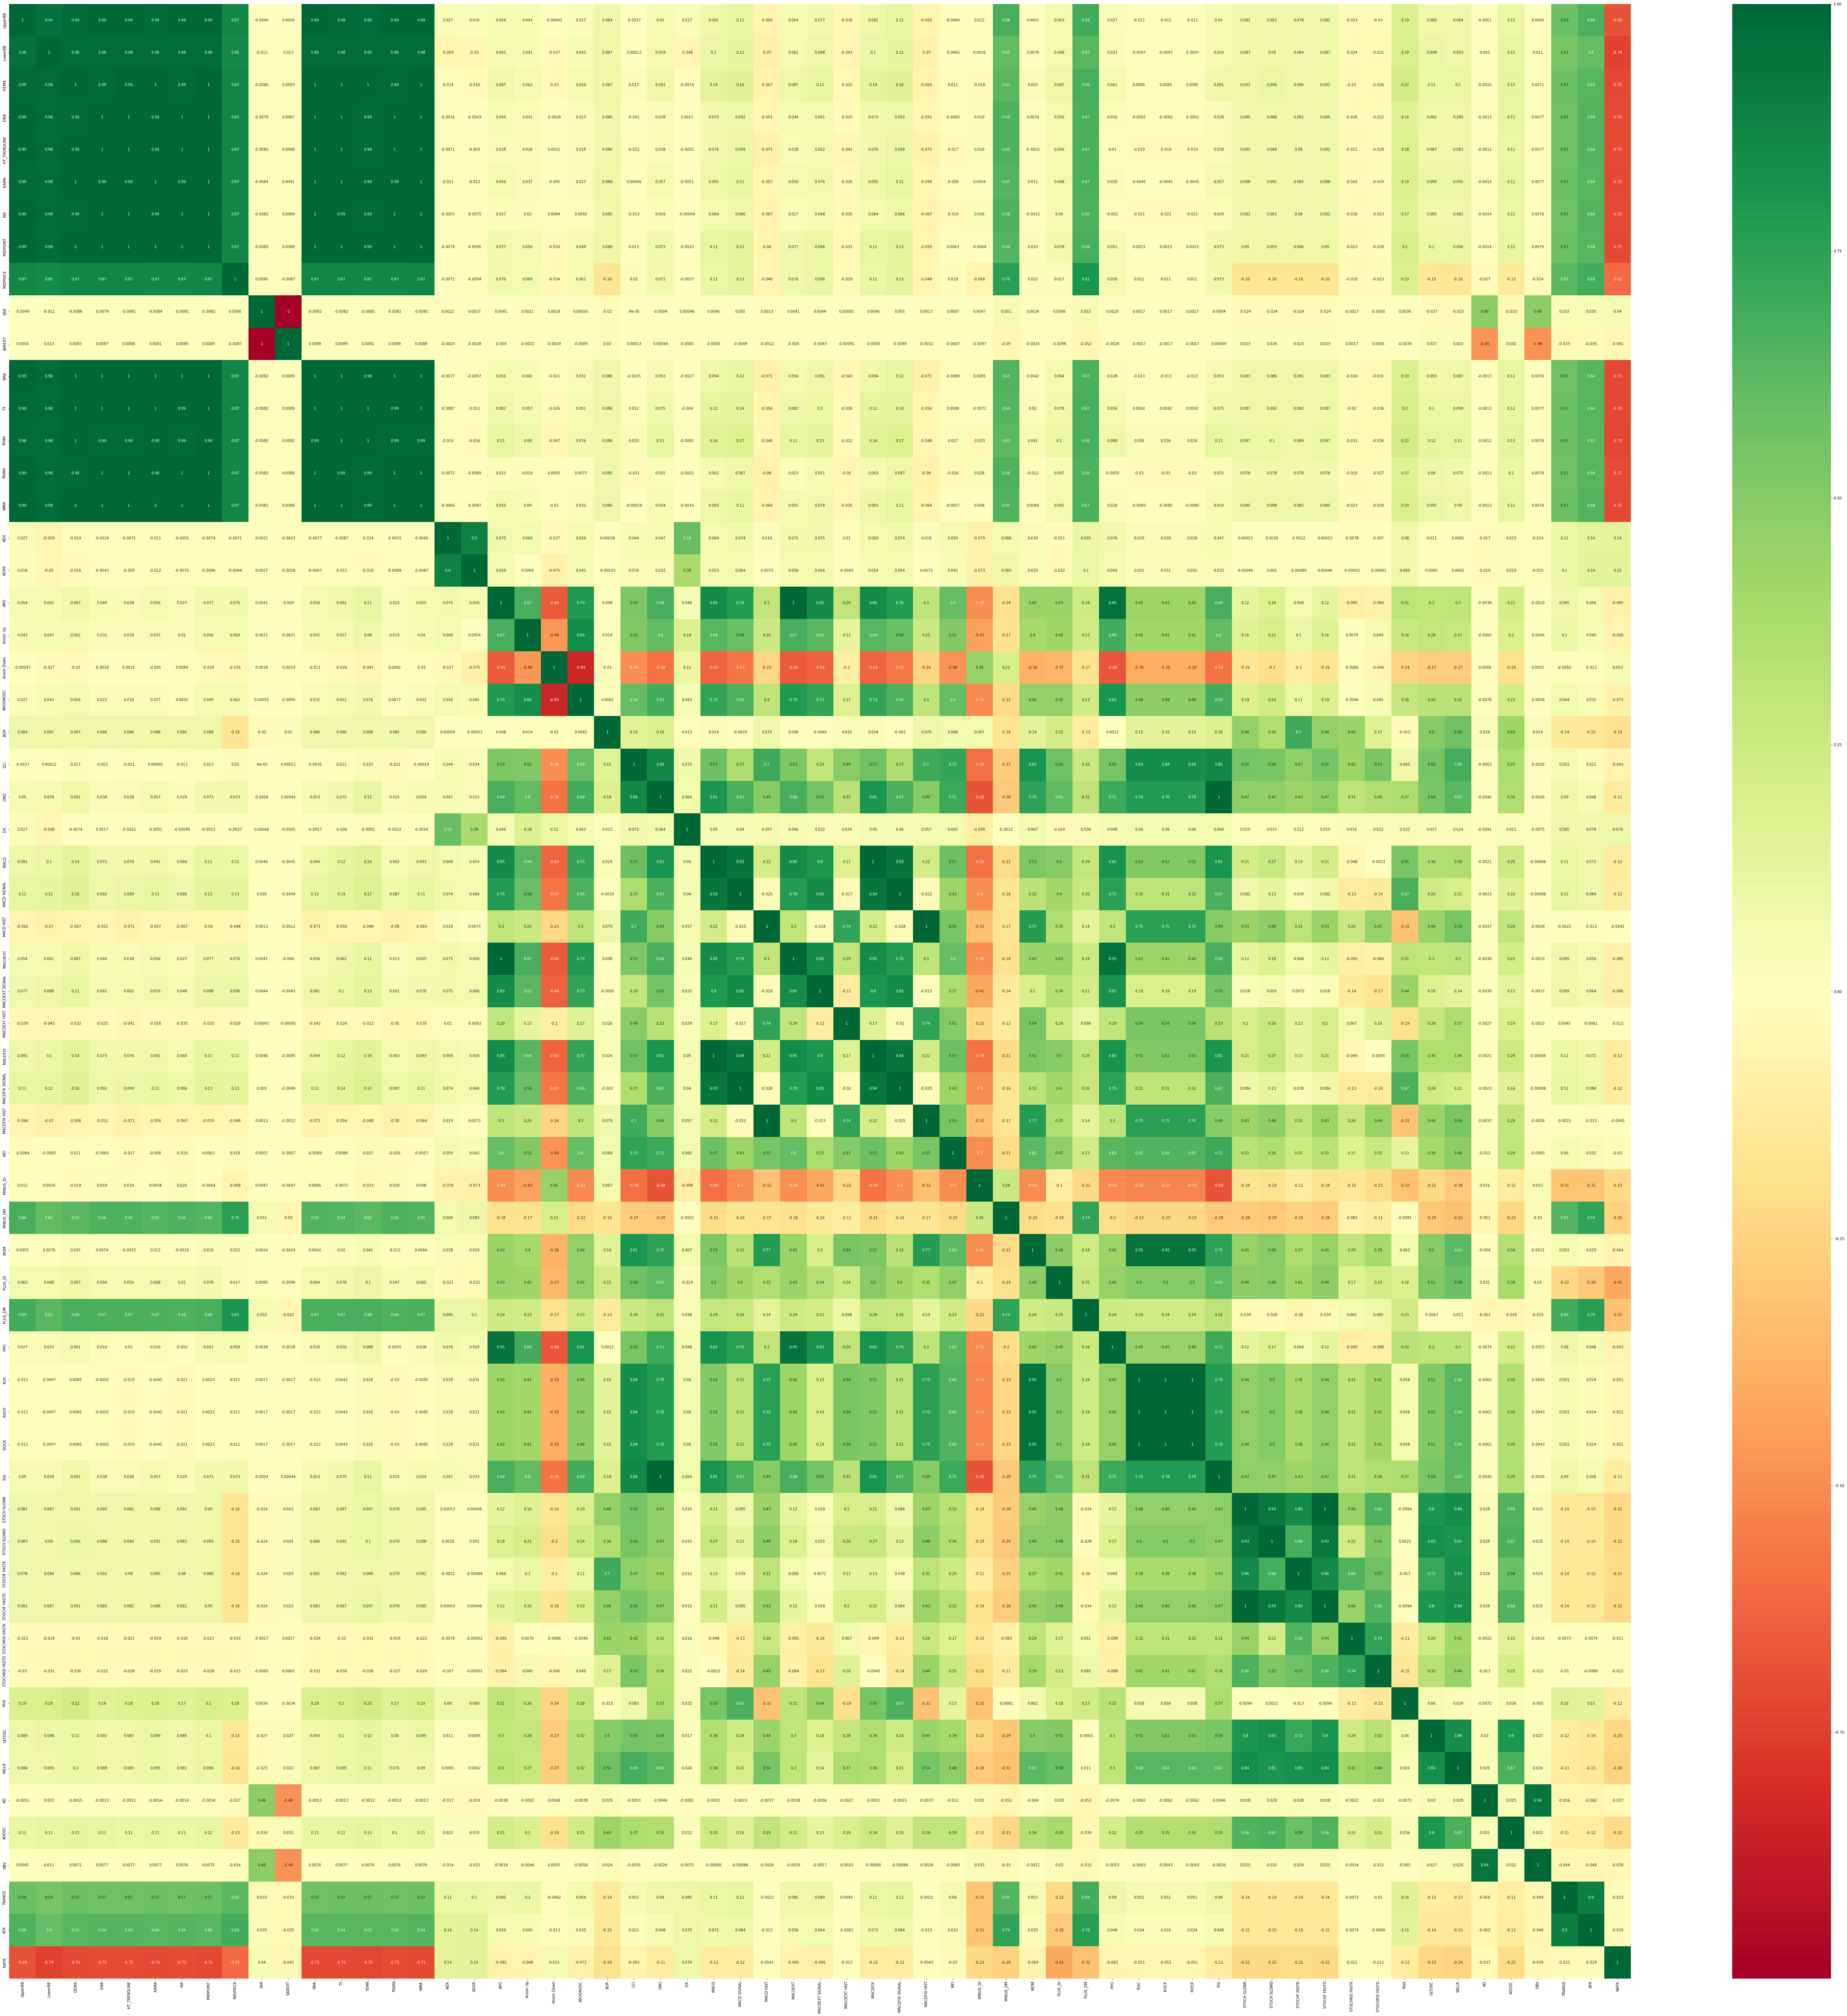

In [70]:
correlation = Correlation()

corr_matrix = correlation.compute_correlation(df, method="spearman")

In [71]:
red_features = correlation.reducing_dimension(corr_matrix, 0.75)

/var/folders/q7/6wv2k6q102g81fj_34rqybkh0000gp/T/ipykernel_7943/3150073786.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))


In [72]:
df_red = df.drop(red_features, axis="columns")
df_red

UpperBB       SAR       ADX       APO  Aroon Up  Aroon Down  \
0        0.005439 -3.300163  0.150016  0.000150  1.431490   -0.722040   
1        0.005457 -3.300163  0.248060  0.000167  1.431490   -0.834299   
2        0.005473 -3.300163  0.362278  0.000188  1.431490   -0.946558   
3        0.005498 -3.300163  0.525776  0.000214  1.431490   -1.058817   
4        0.005514 -3.300163  0.688435  0.000234  1.431490   -1.171076   
...           ...       ...       ...       ...       ...         ...   
2332436  0.003267  0.303015  2.883867 -0.000107 -1.367147    1.523141   
2332437  0.003262  0.303015  2.933762 -0.000112 -1.367147    1.410882   
2332438  0.003258  0.303015  2.993271 -0.000114 -1.143256    1.523141   
2332439  0.003255  0.303015  3.008276 -0.000117 -1.255202    1.410882   
2332440  0.003251  0.303015  2.857384 -0.000113 -1.367147    1.298623   

              BOP       CCI        DX  MACD HIST  ...       MFI  MINUS_DI  \
0       -0.027952  1.268804  0.947760   0.000243  ...  1.455174 -0.889463   
1       -0.028269  1.124132  0.947760   0.000244  ...  1.544671 -0.989793   
2       -0.028981  1.217373  1.149738   0.000243  ...  1.550854 -1.045705   
3       -0.027540  1.440999  1.650272   0.000266  ...  1.627019 -1.104624   
4       -0.031760  1.340987  1.744728   0.000260  ...  1.885930 -1.129947   
...           ...       ...       ...        ...  ...       ...       ...   
2332436 -0.033481 -1.482251  3.148312  -0.000064  ... -3.001967  1.608711   
2332437 -0.031339 -1.256982  2.229866  -0.000068  ... -2.488435  1.296385   
2332438 -0.027658 -1.064326  2.344708  -0.000047  ... -1.961098  1.188769   
2332439 -0.029908 -0.824931  1.993920  -0.000029  ... -1.451755  1.041506   
2332440 -0.029945 -0.534909  0.557578  -0.000003  ... -1.040859  0.737316   

          PLUS_DI  STOCH SLOWK  STOCHRSI FASTK  STOCHRSI FASTD      TRIX  \
0        0.579166    -0.084681        1.189839        1.299807  0.007242   
1        0.320697    -0.081809        1.189839        1.506346  0.007937   
2        0.390304    -0.080851        1.189839        1.506346  0.008808   
3        0.864280    -0.080851        1.189839        1.506346  0.009925   
4        0.919662    -0.082021        0.792125        1.338509  0.011216   
...           ...          ...             ...             ...       ...   
2332436 -1.652091    -0.108253       -1.201417       -0.675528 -0.077595   
2332437 -1.312398    -0.110119       -1.201417       -1.521003 -0.080369   
2332438 -1.382330    -0.106307        1.189839       -0.511887 -0.083088   
2332439 -1.265573    -0.100875        1.142657        0.477318 -0.085725   
2332440 -0.676908    -0.093831        1.189839        1.486435 -0.088134   

               AD    TRANGE      NATR  
0       -0.839920 -0.000697 -0.003473  
1       -0.839920 -0.000697 -0.003473  
2       -0.839920 -0.000697 -0.003473  
3       -0.839920 -0.000697 -0.003473  
4       -0.839920 -0.000697 -0.003473  
...           ...       ...       ...  
2332436  2.226911 -0.000697 -0.003472  
2332437  2.226911 -0.000697 -0.003472  
2332438  2.226911 -0.000697 -0.003472  
2332439  2.226911 -0.000697 -0.003472  
2332440  2.226911 -0.000697 -0.003472  

[2332441 rows x 21 columns]

In [73]:
df_red.to_csv("/Users/admin/Desktop/red_features.csv")

In [88]:
df_2 = pd.read_csv("/Users/admin/Desktop/stock_prices.csv")

In [152]:
adding_columns = adjust_price(df_2)
adding_columns['Close'] = adding_columns['AdjustedClose']
adding_columns = adding_columns.drop(columns='AdjustedClose')

In [153]:
adding_columns = adding_columns[["Date", "SecuritiesCode", "Target"]][90:]
adding_columns.reset_index(drop=True, inplace=True)
adding_columns

Date  SecuritiesCode    Target
0       2017-05-17            1301  0.004862
1       2017-05-18            1301  0.014516
2       2017-05-19            1301 -0.001590
3       2017-05-22            1301  0.011146
4       2017-05-23            1301 -0.014173
...            ...             ...       ...
2332436 2021-11-29            9997  0.026987
2332437 2021-11-30            9997 -0.001460
2332438 2021-12-01            9997  0.017544
2332439 2021-12-02            9997  0.014368
2332440 2021-12-03            9997  0.018414

[2332441 rows x 3 columns]

In [154]:
df_res = pd.concat([adding_columns, df_red], axis=1)
df_res

Date  SecuritiesCode    Target   UpperBB       SAR       ADX  \
0       2017-05-17            1301  0.004862  0.005439 -3.300163  0.150016   
1       2017-05-18            1301  0.014516  0.005457 -3.300163  0.248060   
2       2017-05-19            1301 -0.001590  0.005473 -3.300163  0.362278   
3       2017-05-22            1301  0.011146  0.005498 -3.300163  0.525776   
4       2017-05-23            1301 -0.014173  0.005514 -3.300163  0.688435   
...            ...             ...       ...       ...       ...       ...   
2332436 2021-11-29            9997  0.026987  0.003267  0.303015  2.883867   
2332437 2021-11-30            9997 -0.001460  0.003262  0.303015  2.933762   
2332438 2021-12-01            9997  0.017544  0.003258  0.303015  2.993271   
2332439 2021-12-02            9997  0.014368  0.003255  0.303015  3.008276   
2332440 2021-12-03            9997  0.018414  0.003251  0.303015  2.857384   

              APO  Aroon Up  Aroon Down       BOP  ...       MFI  MINUS_DI  \
0        0.000150  1.431490   -0.722040 -0.027952  ...  1.455174 -0.889463   
1        0.000167  1.431490   -0.834299 -0.028269  ...  1.544671 -0.989793   
2        0.000188  1.431490   -0.946558 -0.028981  ...  1.550854 -1.045705   
3        0.000214  1.431490   -1.058817 -0.027540  ...  1.627019 -1.104624   
4        0.000234  1.431490   -1.171076 -0.031760  ...  1.885930 -1.129947   
...           ...       ...         ...       ...  ...       ...       ...   
2332436 -0.000107 -1.367147    1.523141 -0.033481  ... -3.001967  1.608711   
2332437 -0.000112 -1.367147    1.410882 -0.031339  ... -2.488435  1.296385   
2332438 -0.000114 -1.143256    1.523141 -0.027658  ... -1.961098  1.188769   
2332439 -0.000117 -1.255202    1.410882 -0.029908  ... -1.451755  1.041506   
2332440 -0.000113 -1.367147    1.298623 -0.029945  ... -1.040859  0.737316   

          PLUS_DI  STOCH SLOWK  STOCHRSI FASTK  STOCHRSI FASTD      TRIX  \
0        0.579166    -0.084681        1.189839        1.299807  0.007242   
1        0.320697    -0.081809        1.189839        1.506346  0.007937   
2        0.390304    -0.080851        1.189839        1.506346  0.008808   
3        0.864280    -0.080851        1.189839        1.506346  0.009925   
4        0.919662    -0.082021        0.792125        1.338509  0.011216   
...           ...          ...             ...             ...       ...   
2332436 -1.652091    -0.108253       -1.201417       -0.675528 -0.077595   
2332437 -1.312398    -0.110119       -1.201417       -1.521003 -0.080369   
2332438 -1.382330    -0.106307        1.189839       -0.511887 -0.083088   
2332439 -1.265573    -0.100875        1.142657        0.477318 -0.085725   
2332440 -0.676908    -0.093831        1.189839        1.486435 -0.088134   

               AD    TRANGE      NATR  
0       -0.839920 -0.000697 -0.003473  
1       -0.839920 -0.000697 -0.003473  
2       -0.839920 -0.000697 -0.003473  
3       -0.839920 -0.000697 -0.003473  
4       -0.839920 -0.000697 -0.003473  
...           ...       ...       ...  
2332436  2.226911 -0.000697 -0.003472  
2332437  2.226911 -0.000697 -0.003472  
2332438  2.226911 -0.000697 -0.003472  
2332439  2.226911 -0.000697 -0.003472  
2332440  2.226911 -0.000697 -0.003472  

[2332441 rows x 24 columns]

In [93]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [99]:
def feval_pearsonr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'pearsonr', stats.pearsonr(y_true, y_pred)[0], True

In [128]:
params_lgb = {'learning_rate': 0.005,
              'metric':'None',
              'objective': 'regression',
              'boosting': 'gbdt',
              'verbosity': 0,
              'n_jobs': -1,
              'force_col_wise':True}  

y = df_2.loc[:,'Target'][90:]
y = y.interpolate(method='spline', order=3, limit_direction='both')
X = df_red

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [130]:
model = lgb.train(params = params_lgb, 
                train_set = lgb_train, 
                valid_sets = [lgb_train, lgb_eval], 
                num_boost_round = 10000, 
                feval=feval_pearsonr,
                callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=True)])

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	training's pearsonr: 0.188213	valid_1's pearsonr: 0.18832
Training until validation scores don't improve for 300 rounds
[2]	training's pearsonr: 0.188213	valid_1's pearsonr: 0.18832
[3]	training's pearsonr: 0.188895	valid_1's pearsonr: 0.188938
[4]	training's pearsonr: 0.189655	valid_1's pearsonr: 0.189581
[5]	training's pearsonr: 0.189659	valid_1's pearsonr: 0.189572
[6]	training's pearsonr: 0.189994	valid_1's pearsonr: 0.189883
[7]	training's pearsonr: 0.190426	valid_1's pearsonr: 0.190278
[8]	training's pearsonr: 0.190777	valid_1's pearsonr: 0.190577
[9]	training's pearsonr: 0.190814	valid_1's pearsonr: 0.19056
[10]	training's pearsonr: 0.191095	valid_1's pearsonr: 0.190799
[11]	training's pearsonr: 0.191131	valid_1's pearsonr: 0.190813
[12]	training's pearsonr: 0.191116	valid_1's pearsonr: 0.190774
[13]	training's pearsonr: 0.191176	valid_1's pearsonr: 0.190813
[14]	training's pearsonr: 0.191225	val

In [131]:
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred, y_test)))

0.022031300023651453


In [ ]:
from sklearn.model_selection import KFold

folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds = np.zeros(X.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    trn_x, trn_y = X.iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    lgb_train = lgb.Dataset(trn_x, trn_y)
    lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)
    
    
    model_2 = lgb.train(params = params_lgb, 
                train_set = lgb_train, 
                valid_sets = [lgb_train, lgb_eval], 
                num_boost_round = 10000, 
                feval=feval_pearsonr,
                callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=True)])
    
    oof_preds[val_idx] = model_2.predict(val_x)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	training's pearsonr: 0.1822	valid_1's pearsonr: 0.180242
Training until validation scores don't improve for 300 rounds
[2]	training's pearsonr: 0.1822	valid_1's pearsonr: 0.180242
[3]	training's pearsonr: 0.1822	valid_1's pearsonr: 0.180242
[4]	training's pearsonr: 0.182243	valid_1's pearsonr: 0.180311
[5]	training's pearsonr: 0.182243	valid_1's pearsonr: 0.180301
[6]	training's pearsonr: 0.182257	valid_1's pearsonr: 0.180329
[7]	training's pearsonr: 0.182255	valid_1's pearsonr: 0.18032
[8]	training's pearsonr: 0.182496	valid_1's pearsonr: 0.1805
[9]	training's pearsonr: 0.182472	valid_1's pearsonr: 0.180479
[10]	training's pearsonr: 0.182607	valid_1's pearsonr: 0.180572
[11]	training's pearsonr: 0.182583	valid_1's pearsonr: 0.180553
[12]	training's pearsonr: 0.182668	valid_1's pearsonr: 0.180607
[13]	training's pearsonr: 0.

In [147]:
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred, y_test)))

[LightGBM] [Fatal] The number of features in data (61) is not the same as it was in training data (21).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (61) is not the same as it was in training data (21).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [144]:
params_lgb = {'learning_rate': 0.005,
              'metric':'None',
              'objective': 'regression',
              'boosting': 'gbdt',
              'verbosity': 0,
              'n_jobs': -1,
              'force_col_wise':True}  

y = df_2.loc[:,'Target'][90:]
y = y.interpolate(method='spline', order=3, limit_direction='both')
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [ ]:
model_3 = lgb.train(params = params_lgb, 
                train_set = lgb_train, 
                valid_sets = [lgb_train, lgb_eval], 
                num_boost_round = 10000, 
                feval=feval_pearsonr,
                callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=True)])

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	training's pearsonr: 0.212978	valid_1's pearsonr: 0.211828
Training until validation scores don't improve for 300 rounds
[2]	training's pearsonr: 0.212978	valid_1's pearsonr: 0.211828
[3]	training's pearsonr: 0.212978	valid_1's pearsonr: 0.211828
[4]	training's pearsonr: 0.216114	valid_1's pearsonr: 0.214909
[5]	training's pearsonr: 0.216714	valid_1's pearsonr: 0.215489
[6]	training's pearsonr: 0.216535	valid_1's pearsonr: 0.215302
[7]	training's pearsonr: 0.216117	valid_1's pearsonr: 0.214882
[8]	training's pearsonr: 0.216012	valid_1's pearsonr: 0.214775
[9]	training's pearsonr: 0.215608	valid_1's pearsonr: 0.214381
[10]	training's pearsonr: 0.215174	valid_1's pearsonr: 0.21394
[11]	training's pearsonr: 0.214664	valid_1's pearsonr: 0.213437
[12]	training's pearsonr: 0.214164	valid_1's pearsonr: 0.212942
[13]	training's pear

In [149]:
y_pred = model_3.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred, y_test)))

0.021513408186288715


In [155]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size=200, toprank_weight_ratio=2):
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio#, buf

def add_rank(df):
    df["Rank"] = df.groupby("Date")["Target"].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

def fill_nan_inf(df):
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    return df

def check_score(df,preds,Securities_filter=[]):
    tmp_preds=df[['Date','SecuritiesCode']].copy()
    tmp_preds['Target']=preds
    
    #Rank Filter. Calculate median for this date and assign this value to the list of Securities to filter.
    tmp_preds['target_mean']=tmp_preds.groupby("Date")["Target"].transform('median')
    tmp_preds.loc[tmp_preds['SecuritiesCode'].isin(Securities_filter),'Target']=tmp_preds['target_mean']
    
    tmp_preds = add_rank(tmp_preds)
    df['Rank']=tmp_preds['Rank']
    score=round(calc_spread_return_sharpe(df, portfolio_size= 200, toprank_weight_ratio= 2),5)
    score_mean=round(df.groupby('Date').apply(calc_spread_return_per_day, 200, 2).mean(),5)
    score_std=round(df.groupby('Date').apply(calc_spread_return_per_day, 200, 2).std(),5)
    print(f'Competition_Score:{score}, rank_score_mean:{score_mean}, rank_score_std:{score_std}')
    
def calc_spread_return_per_day(df, portfolio_size=200, toprank_weight_ratio=2):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

In [188]:
test_df = pd.read_csv('/Users/admin/Desktop/stock_prices_test.csv')
test_df

RowId        Date  SecuritiesCode    Open    High     Low  \
0       20211206_1301  2021-12-06            1301  2982.0  2982.0  2965.0   
1       20211206_1332  2021-12-06            1332   592.0   599.0   588.0   
2       20211206_1333  2021-12-06            1333  2368.0  2388.0  2360.0   
3       20211206_1375  2021-12-06            1375  1230.0  1239.0  1224.0   
4       20211206_1376  2021-12-06            1376  1339.0  1372.0  1339.0   
...               ...         ...             ...     ...     ...     ...   
269876  20220624_9990  2022-06-24            9990   576.0   576.0   563.0   
269877  20220624_9991  2022-06-24            9991   810.0   815.0   804.0   
269878  20220624_9993  2022-06-24            9993  1548.0  1548.0  1497.0   
269879  20220624_9994  2022-06-24            9994  2507.0  2527.0  2498.0   
269880  20220624_9997  2022-06-24            9997   710.0   725.0   710.0   

         Close   Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
0       2971.0     8900               1.0               NaN            False   
1        589.0  1360800               1.0               NaN            False   
2       2377.0   125900               1.0               NaN            False   
3       1224.0    81100               1.0               NaN            False   
4       1351.0     6200               1.0               NaN            False   
...        ...      ...               ...               ...              ...   
269876   564.0    24200               1.0               NaN            False   
269877   815.0     8700               1.0               NaN            False   
269878  1497.0    12600               1.0               NaN            False   
269879  2527.0     7300               1.0               NaN            False   
269880   719.0   139600               1.0               NaN            False   

          Target  
0      -0.003263  
1      -0.008993  
2      -0.009963  
3      -0.015032  
4       0.002867  
...          ...  
269876  0.027073  
269877  0.001220  
269878  0.001329  
269879  0.003185  
269880  0.015089  

[269881 rows x 12 columns]

In [189]:
sec_codes = test_df.SecuritiesCode.unique().tolist()
for code in sec_codes:
    test_df.loc[test_df.SecuritiesCode == code, "High"] = test_df[test_df.SecuritiesCode == code]["High"].interpolate(method='spline', order=3, limit_direction='both')
    test_df.loc[test_df.SecuritiesCode == code, "Low"] = test_df[test_df.SecuritiesCode == code]["Low"].interpolate(method='spline', order=3, limit_direction='both')
    test_df.loc[test_df.SecuritiesCode == code , "Close"] = test_df[test_df.SecuritiesCode == code]["Close"].interpolate(method='spline', order=3, limit_direction='both')
    test_df.loc[test_df.SecuritiesCode == code , "Open"] = test_df[test_df.SecuritiesCode == code]["Open"].interpolate(method='spline', order=3, limit_direction='both')

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [190]:
test_df = adjust_price(test_df)
test_df['Close'] = test_df['AdjustedClose']
test_df = test_df.drop(columns='AdjustedClose')

In [174]:
test_df['Target'] = test_df.loc[:,'Target'].interpolate(method='spline', order=3, limit_direction='both')
test_df.isna().sum()

RowId                              0
Date                               0
SecuritiesCode                     0
Open                               0
High                               0
Low                                0
Close                              0
Volume                             0
AdjustmentFactor                   0
ExpectedDividend              267870
SupervisionFlag                    0
Target                             0
CumulativeAdjustmentFactor         0
dtype: int64

In [191]:
test_df = compute_all_indicators(test_df)
test_df

RowId       Date  SecuritiesCode    Open    High     Low  \
0       20211206_1301 2021-12-06            1301  2982.0  2982.0  2965.0   
1       20211207_1301 2021-12-07            1301  2998.0  3065.0  2990.0   
2       20211208_1301 2021-12-08            1301  3080.0  3080.0  3035.0   
3       20211209_1301 2021-12-09            1301  3050.0  3085.0  3025.0   
4       20211210_1301 2021-12-10            1301  3100.0  3105.0  3050.0   
...               ...        ...             ...     ...     ...     ...   
269876  20220620_9997 2022-06-20            9997   693.0   697.0   683.0   
269877  20220621_9997 2022-06-21            9997   692.0   709.0   692.0   
269878  20220622_9997 2022-06-22            9997   706.0   716.0   703.0   
269879  20220623_9997 2022-06-23            9997   704.0   713.0   704.0   
269880  20220624_9997 2022-06-24            9997   710.0   725.0   710.0   

         Close  Volume  AdjustmentFactor  ExpectedDividend  ...  \
0       2971.0    8900               1.0               0.0  ...   
1       3065.0   19100               1.0               0.0  ...   
2       3055.0   11600               1.0               0.0  ...   
3       3085.0   11700               1.0               0.0  ...   
4       3105.0   14700               1.0               0.0  ...   
...        ...     ...               ...               ...  ...   
269876   687.0  122600               1.0               0.0  ...   
269877   706.0  204800               1.0               0.0  ...   
269878   707.0  150200               1.0               0.0  ...   
269879   707.0  114700               1.0               0.0  ...   
269880   719.0  139600               1.0               0.0  ...   

        STOCHRSI FASTD      TRIX     ULTOSC      WILLR            AD  \
0             0.000000  0.000000   0.000000   0.000000 -2.617647e+03   
1             0.000000  0.000000   0.000000   0.000000  1.648235e+04   
2             0.000000  0.000000   0.000000   0.000000  1.519346e+04   
3             0.000000  0.000000   0.000000   0.000000  2.689346e+04   
4             0.000000  0.000000   0.000000   0.000000  4.159346e+04   
...                ...       ...        ...        ...           ...   
269876       66.666667 -0.205482  46.508659 -44.736842  3.734467e+10   
269877       66.666667 -0.197325  55.533480  -6.976744  3.734480e+10   
269878       66.666667 -0.188605  53.352351 -18.000000  3.734475e+10   
269879      100.000000 -0.179472  52.188272 -18.000000  3.734471e+10   
269880      100.000000 -0.169603  53.590318 -12.500000  3.734473e+10   

                ADOSC           OBV  TRANGE        ATR      NATR  
0            0.000000  8.900000e+03     0.0   0.000000  0.000000  
1            0.000000  2.800000e+04    94.0   0.000000  0.000000  
2            0.000000  1.640000e+04    45.0   0.000000  0.000000  
3            0.000000  2.810000e+04    60.0   0.000000  0.000000  
4            0.000000  4.280000e+04    55.0   0.000000  0.000000  
...               ...           ...     ...        ...       ...  
269876   74655.645241  1.356128e+09    14.0  13.307540  0.281958  
269877  119481.017883  1.356332e+09    22.0  13.928430  0.279443  
269878  108575.640739  1.356483e+09    13.0  13.862113  0.277326  
269879   82078.685776  1.356483e+09     9.0  13.514820  0.270378  
269880   72660.960037  1.356622e+09    18.0  13.835190  0.267625  

[269881 rows x 74 columns]

In [192]:
test_df = test_df.drop(columns=['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag', 'CumulativeAdjustmentFactor'])

In [199]:
test_df = test_df.iloc[30:] #выкинуть 90
test_df.reset_index(drop=True, inplace=True)

In [201]:
test_df = z_score(test_df)

In [202]:
test_df

Target   UpperBB   LowerBB      DEMA       EMA  HT_TRENDLINE  \
0       0.335712  0.003660  0.045980  0.065444  0.090080      0.100026   
1      -0.052935  0.003307  0.045573  0.064451  0.089429      0.099404   
2      -0.310865  0.002902  0.045377  0.063863  0.089048      0.098862   
3       0.596049  0.002048  0.045612  0.063266  0.088647      0.098329   
4      -0.821395  0.001223  0.045803  0.062412  0.088043      0.097613   
...          ...       ...       ...       ...       ...           ...   
269786  0.070678 -0.065654 -0.046747 -0.198979 -0.279272     -0.279948   
269787  0.011424 -0.065572 -0.046676 -0.198659 -0.279084     -0.279940   
269788  0.721463 -0.065542 -0.046487 -0.198356 -0.278899     -0.279923   
269789  0.593248 -0.065528 -0.046288 -0.198080 -0.278725     -0.279850   
269790  0.642651 -0.065463 -0.046135 -0.197679 -0.278453     -0.279773   

            KAMA        MA  MIDPOINT  MIDPRICE  ...  STOCHRSI FASTD      TRIX  \
0       0.004692  0.093461  0.024261  0.172200  ...       -0.992848  0.112329   
1       0.004684  0.093461  0.024261  0.172200  ...       -0.684520  0.105735   
2       0.004676  0.093623  0.023926  0.171590  ...        0.304831  0.099221   
3       0.004669  0.093530  0.023591  0.170368  ...        1.232935  0.092787   
4       0.004658  0.093414  0.023144  0.169147  ...        1.041621  0.086300   
...          ...       ...       ...       ...  ...             ...       ...   
269786 -0.059785 -0.276102 -0.093046 -0.467758  ...        0.481808 -0.174982   
269787 -0.059782 -0.276125 -0.092845 -0.467148  ...        0.481808 -0.168251   
269788 -0.059779 -0.276107 -0.092756 -0.466293  ...        0.481808 -0.161055   
269789 -0.059770 -0.275986 -0.092622 -0.466293  ...        1.471159 -0.153517   
269790 -0.059763 -0.275935 -0.092242 -0.463850  ...        1.471159 -0.145374   

          ULTOSC     WILLR        AD     ADOSC       OBV    TRANGE       ATR  \
0      -0.017904 -0.050743 -0.412593 -0.014575  0.257266 -0.005900 -0.018159   
1       0.003581 -0.035119 -0.412592 -0.014431  0.257296 -0.005540 -0.018234   
2       0.013606 -0.024764 -0.412591 -0.014279  0.257319 -0.005900 -0.018392   
3       0.018314 -0.025583 -0.412590 -0.014098  0.257298 -0.005780 -0.018510   
4       0.016052 -0.035079 -0.412589 -0.013941  0.257268 -0.005059 -0.018440   
...          ...       ...       ...       ...       ...       ...       ...   
269786 -0.013988  0.001680  2.447458 -0.012025  2.708127 -0.006285 -0.021847   
269787  0.017413  0.041503  2.447468 -0.010710  2.708498 -0.006093 -0.021795   
269788  0.009824  0.029878  2.447463 -0.011030  2.708769 -0.006309 -0.021801   
269789  0.005774  0.029878  2.447460 -0.011807  2.708769 -0.006405 -0.021830   
269790  0.010652  0.035678  2.447462 -0.012083  2.709021 -0.006189 -0.021803   

            NATR  
0      -0.041857  
1      -0.042011  
2      -0.042190  
3      -0.042270  
4      -0.042162  
...          ...  
269786 -0.026527  
269787 -0.026698  
269788 -0.026842  
269789 -0.027315  
269790 -0.027502  

[269791 rows x 62 columns]

In [214]:
X_test = test_df.drop(columns="Target")
y_test = test_df.loc[:, :"Target"]

In [215]:
y_pred = model_3.predict(X_test)
print(np.sqrt(mean_squared_error(y_pred, y_test)))

0.9999779136466654


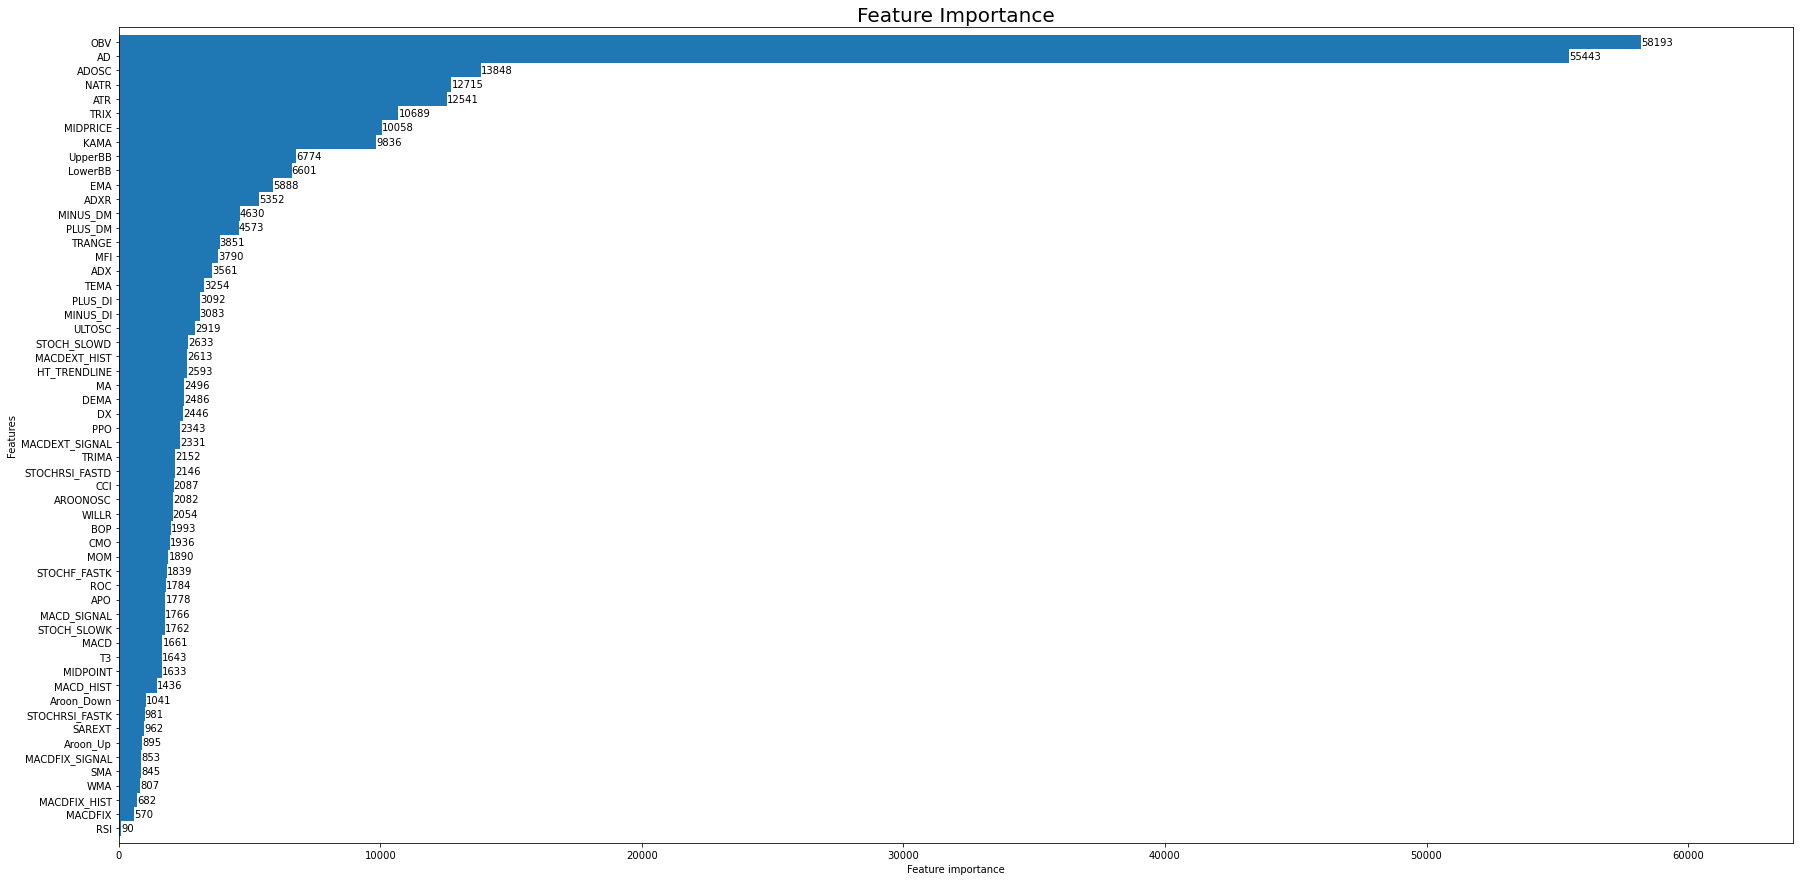

In [216]:
fig, ax = plt.subplots(figsize=(30,15))
lgb.plot_importance(model_3, height=1, ax=ax)
ax.grid(False)
plt.title("Feature Importance", fontsize=20)
plt.show()

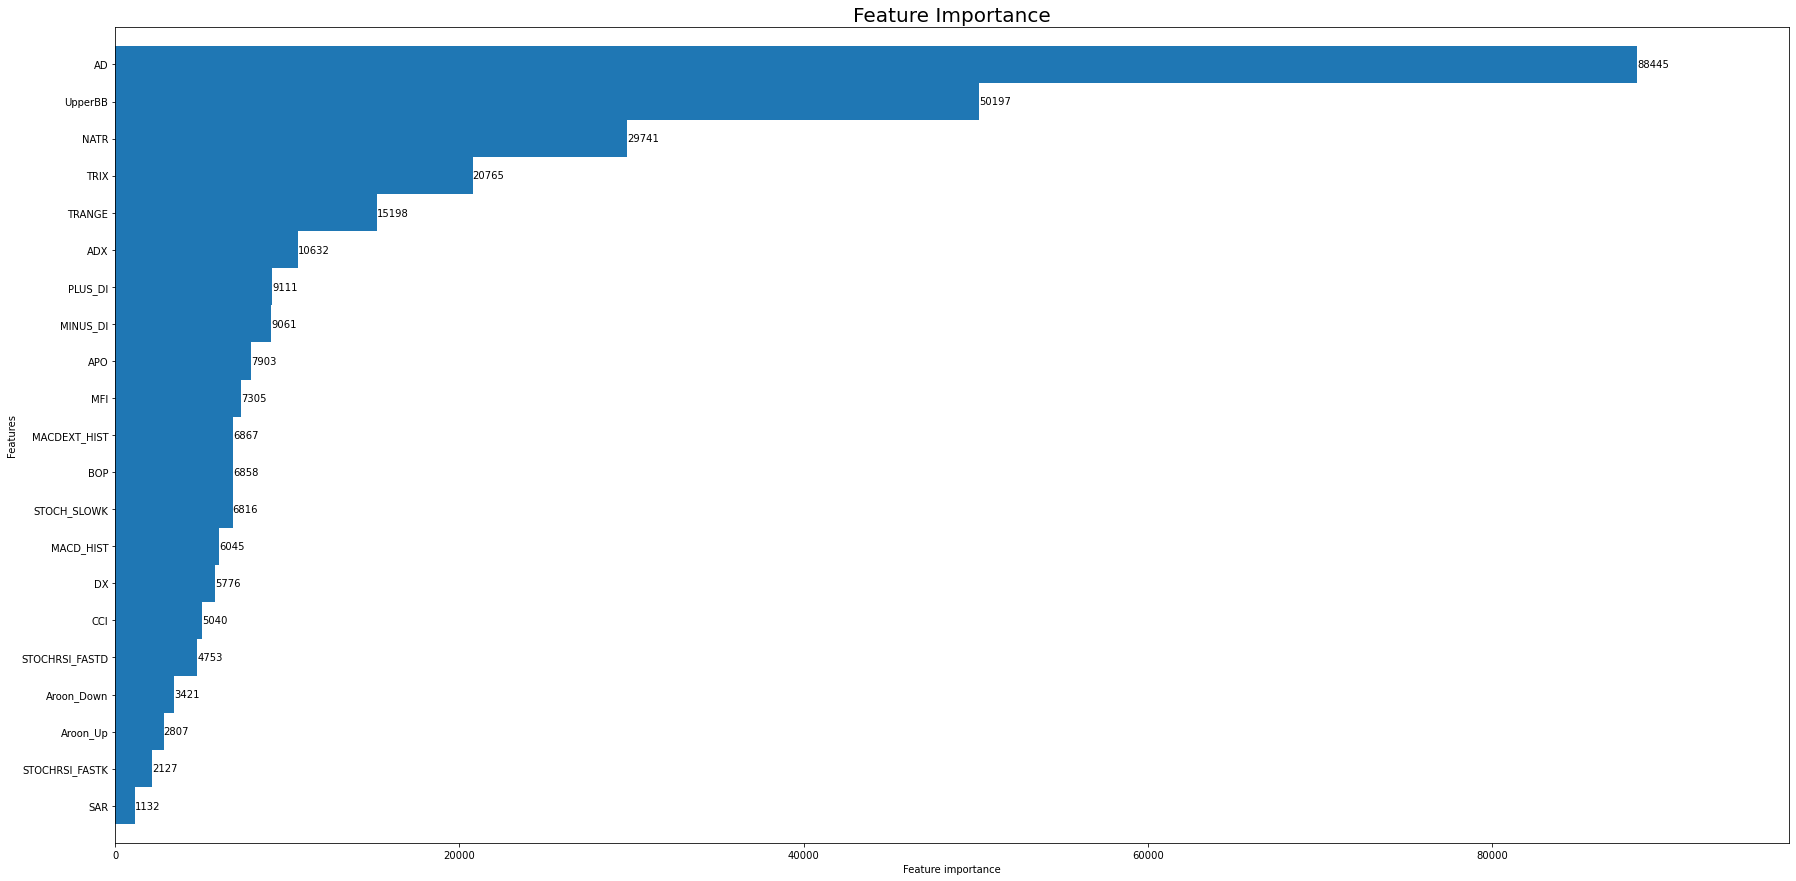

In [217]:
fig, ax = plt.subplots(figsize=(30,15))
lgb.plot_importance(model, height=1, ax=ax)
ax.grid(False)
plt.title("Feature Importance", fontsize=20)
plt.show()